In [26]:
import sys
sys.path.append('../')

import segment_tiles as st
import src.load_data as ld
import src.format_axis as fmt
import importlib
from skimage.feature import greycomatrix, greycoprops
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import time
import pandas as pd
from pathlib import Path
import cv2

Warning image not found: /Users/akre96/Data/BE_224B/Density Research Lab 18 samples/D3 R1 day 9/Image4_dots.tif


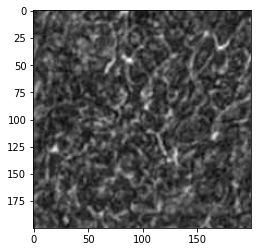

In [5]:
importlib.reload(ld)
config_path = '../config/config.json'
param_config_path = '../config/optimal_tile_params.json'

tiles, metadata = ld.get_all_lsc_images(get_tile=True, output_color = cv2.IMREAD_GRAYSCALE, config_path=config_path)
plt.imshow(tiles[0], cmap='gray');

In [6]:
tile_glcm = metadata.copy()
tile_glcm['contrast'] = 0.0
tile_glcm['energy'] = 0.0
for i, row in metadata.iterrows():
    tile = tiles[i]
    glcm = greycomatrix(tile, [10], [0], symmetric=True, normed=True)
    contrast = greycoprops(glcm, 'contrast')
    energy = greycoprops(glcm, 'energy')
    tile_glcm.loc[tile_glcm.index == i, ['contrast', 'energy']] = [contrast, energy]

In [7]:
tile_glcm.describe()

,image_num,contrast,energy
count,141.000000,141.000000,141.000000
mean,4.872340,130.962813,0.039913
std,2.848185,50.074223,0.006980
min,1.000000,53.044316,0.026725
25%,3.000000,93.612974,0.034910
50%,5.000000,126.130368,0.039023
75%,7.000000,154.017158,0.044225
max,16.000000,322.755737,0.061446


In [36]:
import cv2
importlib.reload(ld)
images, img_metadata = ld.get_all_lsc_images(get_tile=False, output_color=cv2.IMREAD_UNCHANGED, config_path=config_path)

In [47]:
img_metadata
print(img_metadata.groupby('subject').image_num.count())
print(img_metadata.subject.nunique())
print(len(images))

subject
D1 R1    8
D1 R2    7
D1 R3    7
D1 R4    8
D1 R5    8
D1 R6    8
D2 R1    8
D2 R2    8
D2 R3    8
D2 R4    8
D2 R5    8
D2 R6    8
D3 R1    8
D3 R2    8
D3 R3    8
D3 R4    8
D3 R5    8
D3 R6    8
Name: image_num, dtype: int64
18
142


In [16]:
from tqdm import tqdm
importlib.reload(st)
gen_tiles_glcm = pd.DataFrame()
tile_select_params = ld.get_tile_select_params(param_config_path)['LSC']
tile_select_params['glcm_n_samples'] = 100
segmenter = st.TileSegmenter(
    **tile_select_params,
    plot_patches=False,
    show_tqdm=False,
)
for i, row in tqdm(img_metadata.iterrows(), desc='finding GLCM props on generated tiles', total=img_metadata.shape[0]):
    img = images[i]
    gen_tiles = segmenter.segment_tiles(img)
    for j, tile in enumerate(gen_tiles):
        img_rep = row.copy()
        if len(tile.shape) == 3:
            tile = cv2.cvtColor(tile, cv2.COLOR_BGR2GRAY)
        glcm = greycomatrix(tile, [10], [0], symmetric=True, normed=True)
        img_rep['rep_n'] = j
        img_rep['contrast'] = greycoprops(glcm, 'contrast')[0][0]
        img_rep['energy'] = greycoprops(glcm, 'energy')[0][0]
        gen_tiles_glcm = gen_tiles_glcm.append(img_rep)


finding GLCM props on generated tiles:   1%|▏         | 2/142 [00:06<07:06,  3.05s/it]


KeyboardInterrupt: 

In [148]:
gen_tiles_glcm['contrast'] = [v[0][0] for v in gen_tiles_glcm['contrast'].values]
gen_tiles_glcm['energy'] = [v[0][0] for v in gen_tiles_glcm['energy'].values]
gen_tiles_glcm_save = gen_tile_glcm

In [144]:
gen_tiles_glcm.describe()

,contrast,energy,image_num,rep_n
count,710.000000,710.000000,710.000000,710.000000
mean,133.217377,0.040464,4.866197,2.000000
std,66.754810,0.010031,2.830991,1.415211
min,16.998711,0.020027,1.000000,0.000000
25%,86.528625,0.033216,3.000000,1.000000
50%,118.379053,0.039696,5.000000,2.000000
75%,169.304349,0.045969,7.000000,3.000000
max,427.483579,0.092011,16.000000,4.000000


In [145]:
merged = gen_tiles_glcm.merge(tile_glcm, on=['image_num', 'subject'], validate='m:1', suffixes=('_gen', '_gt'))
merged

,contrast_gen,energy_gen,image_num,rep_n,subject,contrast_gt,energy_gt
0,141.996474,0.036879,8.0,0.0,D3 R3,174.172184,0.033984
1,196.663079,0.030889,8.0,1.0,D3 R3,174.172184,0.033984
2,210.591184,0.030461,8.0,2.0,D3 R3,174.172184,0.033984
3,163.267684,0.036242,8.0,3.0,D3 R3,174.172184,0.033984
4,76.386132,0.047396,8.0,4.0,D3 R3,174.172184,0.033984
...,...,...,...,...,...,...,...
700,104.831421,0.041799,3.0,0.0,D1 R2,101.175316,0.042461
701,113.556974,0.039730,3.0,1.0,D1 R2,101.175316,0.042461
702,94.142158,0.045217,3.0,2.0,D1 R2,101.175316,0.042461
703,58.805237,0.052538,3.0,3.0,D1 R2,101.175316,0.042461


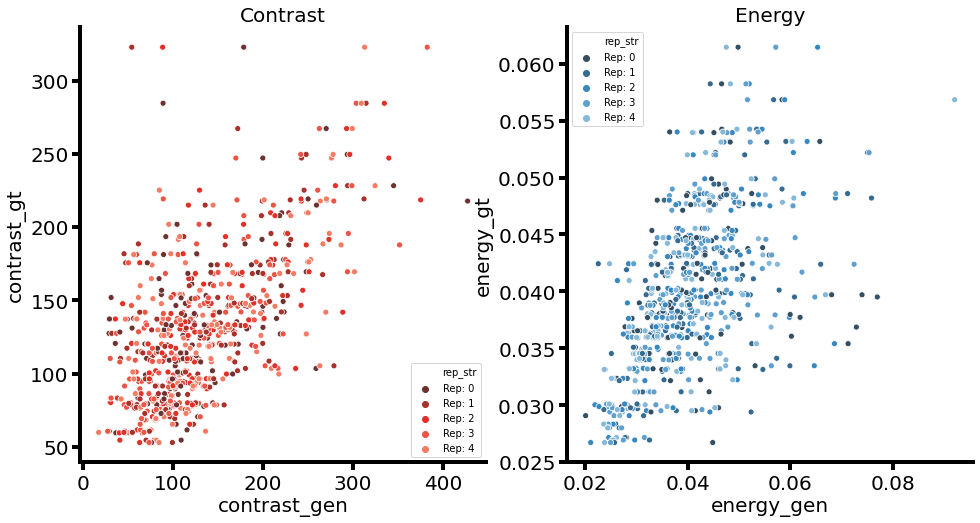

In [146]:
import src.format_axis as fa
importlib.reload(fa)

fig, axes = plt.subplots(ncols=2, figsize=(16,8))
merged['rep_str'] = merged['rep_n'].astype(int).astype(str)
merged['rep_str'] = 'Rep: ' + merged['rep_str']

sns.scatterplot(
    x='contrast_gen',
    y='contrast_gt',
    hue='rep_str',
    palette='Reds_d',
    data=merged,
    ax=axes[0]
)
axes[0].set_title('Contrast', fontsize=20)
sns.scatterplot(
    x='energy_gen',
    y='energy_gt',
    hue='rep_str',
    data=merged,
    ax=axes[1],
    palette='Blues_d'
)
axes[1].set_title('Energy', fontsize=20)

for axis in axes.flatten():
    fa.despine_thicken_axes(axis, fontsize=20)

In [9]:
import time
from pathlib import Path

def calc_metrics_glcm(args):
    start = time.time()
    images, img_metadata = ld.get_all_lsc_images(get_tile=False)
    ns, ed_w, co_w, en_w = args
    gen_tiles_glcm = pd.DataFrame()
    segmenter = st.TileSegmenter(
        n_tiles=5,
        tile_size=200,
        min_tile_dist=200,
        glcm_n_samples=ns,
        edge_weight=ed_w,
        contrast_weight=co_w,
        energy_weight=en_w,
        canny_sigma=2.0,
        plot_patches=False,
        show_tqdm=False,
    )
    desc = 'GLCM sub samples: ' + str(ns) \
            + ' Edge: ' + str(ed_w) \
            + ' Contrast: ' + str(co_w) \
            + ' Energy: ' + str(en_w)
    file_name = 'GLCM_vals_ns' + str(ns) \
            + '_edge' + str(ed_w) \
            + '_contrast' + str(co_w) \
            + '_energy' + str(en_w) \
            + '.csv'
    file_path = Path('lsc_gridsearch_tile_glcm/' + file_name)
    print('Running -- ', desc)
    if file_path.is_file():
        print('\tFound file, skipping')
        return
    
    for i, row in img_metadata.iterrows():
        img = images[i]
        gen_tiles = segmenter.segment_tiles(img)
        for j, tile in enumerate(gen_tiles):
            img_rep = row.copy()
            try:
                glcm = greycomatrix(tile, [10], [0], symmetric=True, normed=True)
            except ValueError:
                continue
            img_rep['rep_n'] = j
            img_rep['contrast'] = greycoprops(glcm, 'contrast')[0][0]
            img_rep['energy'] = greycoprops(glcm, 'energy')[0][0]
            gen_tiles_glcm = gen_tiles_glcm.append(img_rep)
            
            
    gen_tiles_glcm['ns'] = ns
    gen_tiles_glcm['ed_w'] = ed_w
    gen_tiles_glcm['co_w'] = co_w
    gen_tiles_glcm['en_w'] = en_w
    gen_tiles_glcm.to_csv('lsc_gridsearch_tile_glcm/' + file_name)
    stop = time.time()
    print('Finished Run -- ', desc,
          '\n\tTime For Run (mins):', (stop-start)/60,
          '\n\tSaving to:', file_name
     )


In [10]:
from itertools import product
from multiprocessing import Pool
glcm_n_samples = [50, 100, 500, 5]
edge_weights = [-5, -3, -1, 0]
contrast_weight = [3, 2, 1, 0]
energy_weight = [3, 2, 1, 0]

start = time.time()
inputs = product(glcm_n_samples, edge_weights, contrast_weight, energy_weight)
def gen_file_name(args):
    ns, ed_w, co_w, en_w = args
    file_name = 'GLCM_vals_ns' + str(ns) \
            + '_edge' + str(ed_w) \
            + '_contrast' + str(co_w) \
            + '_energy' + str(en_w) \
            + '.csv'
    file_path = Path('lsc_gridsearch_tile_glcm/' + file_name)
    return file_path
todo = [arg for arg in inputs if not gen_file_name(arg).is_file()]

with Pool() as pool:
    pool.map(calc_metrics_glcm, todo)
stop = time.time()
print('Time For All (mins):', (stop-start)/60)

Running --  GLCM sub samples: 5 Edge: -5 Contrast: 0 Energy: 0
Running --  GLCM sub samples: 5 Edge: -5 Contrast: 3 Energy: 3
Running --  GLCM sub samples: 5 Edge: -5 Contrast: 1 Energy: 2
Running --  GLCM sub samples: 5 Edge: -5 Contrast: 2 Energy: 1
Running --  GLCM sub samples: 5 Edge: -5 Contrast: 0 Energy: 3
Running --  GLCM sub samples: 50 Edge: 0 Contrast: 0 Energy: 0
Running --  GLCM sub samples: 5 Edge: -5 Contrast: 3 Energy: 0
Running --  GLCM sub samples: 5 Edge: -3 Contrast: 3 Energy: 1


/Users/akre96/Code/homework_code/BE224B/venv/lib/python3.7/site-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type bool to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/Users/akre96/Code/homework_code/BE224B/venv/lib/python3.7/site-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type bool to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/Users/akre96/Code/homework_code/BE224B/venv/lib/python3.7/site-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type bool to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/Users/akre96/Code/homework_code/BE224B/venv/lib/python3.7/site-packages/skimage/filters/rank/

Finished Run --  GLCM sub samples: 5 Edge: -5 Contrast: 1 Energy: 2 
	Time For Run (mins): 10.85453306833903 
	Saving to: GLCM_vals_ns5_edge-5_contrast1_energy2.csv
Finished Run --  GLCM sub samples: 5 Edge: -5 Contrast: 0 Energy: 3 
	Time For Run (mins): 10.858007435003916 
	Saving to: GLCM_vals_ns5_edge-5_contrast0_energy3.csv
Finished Run --  GLCM sub samples: 5 Edge: -5 Contrast: 2 Energy: 1 
	Time For Run (mins): 10.869996949036915 
	Saving to: GLCM_vals_ns5_edge-5_contrast2_energy1.csv
Finished Run --  GLCM sub samples: 5 Edge: -5 Contrast: 0 Energy: 0 
	Time For Run (mins): 10.895130797227223 
	Saving to: GLCM_vals_ns5_edge-5_contrast0_energy0.csv
Finished Run --  GLCM sub samples: 5 Edge: -5 Contrast: 3 Energy: 3 
	Time For Run (mins): 10.895530899365744 
	Saving to: GLCM_vals_ns5_edge-5_contrast3_energy3.csv
Finished Run --  GLCM sub samples: 5 Edge: -5 Contrast: 3 Energy: 0 
	Time For Run (mins): 10.896156346797943 
	Saving to: GLCM_vals_ns5_edge-5_contrast3_energy0.csv
Runni

In [2]:
import dask.dataframe as dd

# Easiest way to load a bunch of CSVs to 1 pandas dataframe
metrics = dd.read_csv('../lsc_gridsearch_tile_glcm/*.csv').compute()

In [8]:
# Add original tile GLCM data for comparison
merged = metrics.merge(tile_glcm, on=['image_num', 'subject'],validate='m:1', suffixes=('_gen', '_gt'))

In [9]:
merged.groupby(['ns', 'ed_w', 'co_w', 'en_w']).describe()

Unnamed: 0                                               \
                        count       mean       std  min   25%   50%    75%   
ns  ed_w co_w en_w                                                           
5   -5   0    0         564.0  70.865248  40.94136  0.0  36.0  71.0  106.0   
              1         564.0  70.865248  40.94136  0.0  36.0  71.0  106.0   
              2         564.0  70.865248  40.94136  0.0  36.0  71.0  106.0   
              3         564.0  70.865248  40.94136  0.0  36.0  71.0  106.0   
         1    0         564.0  70.865248  40.94136  0.0  36.0  71.0  106.0   
...                       ...        ...       ...  ...   ...   ...    ...   
500  0   2    3         705.0  70.865248  40.93409  0.0  36.0  71.0  106.0   
         3    0         705.0  70.865248  40.93409  0.0  36.0  71.0  106.0   
              1         705.0  70.865248  40.93409  0.0  36.0  71.0  106.0   
              2         705.0  70.865248  40.93409  0.0  36.0  71.0  106.0   
              3         705.0  70.865248  40.93409  0.0  36.0  71.0  106.0   

                          contrast_gen              ... contrast_gt  \
                      max        count        mean  ...         75%   
ns  ed_w co_w en_w                                  ...               
5   -5   0    0     141.0        564.0  117.946245  ...  154.017158   
              1     141.0        564.0  117.946245  ...  154.017158   
              2     141.0        564.0  117.946245  ...  154.017158   
              3     141.0        564.0  117.946245  ...  154.017158   
         1    0     141.0        564.0  117.946245  ...  154.017158   
...                   ...          ...         ...  ...         ...   
500  0   2    3     141.0        705.0  138.174555  ...  154.017158   
         3    0     141.0        705.0  173.049047  ...  154.017158   
              1     141.0        705.0  168.449309  ...  154.017158   
              2     141.0        705.0  163.641035  ...  154.017158   
              3     141.0        705.0  153.708450  ...  154.017158   

                               energy_gt                                \
                           max     count      mean       std       min   
ns  ed_w co_w en_w                                                       
5   -5   0    0     322.755737     564.0  0.039913  0.006961  0.026725   
              1     322.755737     564.0  0.039913  0.006961  0.026725   
              2     322.755737     564.0  0.039913  0.006961  0.026725   
              3     322.755737     564.0  0.039913  0.006961  0.026725   
         1    0     322.755737     564.0  0.039913  0.006961  0.026725   
...                        ...       ...       ...       ...       ...   
500  0   2    3     322.755737     705.0  0.039913  0.006960  0.026725   
         3    0     322.755737     705.0  0.039913  0.006960  0.026725   
              1     322.755737     705.0  0.039913  0.006960  0.026725   
              2     322.755737     705.0  0.039913  0.006960  0.026725   
              3     322.755737     705.0  0.039913  0.006960  0.026725   

                                                           
                        25%       50%       75%       max  
ns  ed_w co_w en_w                                         
5   -5   0    0     0.03491  0.039023  0.044225  0.061446  
              1     0.03491  0.039023  0.044225  0.061446  
              2     0.03491  0.039023  0.044225  0.061446  
              3     0.03491  0.039023  0.044225  0.061446  
         1    0     0.03491  0.039023  0.044225  0.061446  
...                     ...       ...       ...       ...  
500  0   2    3     0.03491  0.039023  0.044225  0.061446  
         3    0     0.03491  0.039023  0.044225  0.061446  
              1     0.03491  0.039023  0.044225  0.061446  
              2     0.03491  0.039023  0.044225  0.061446  
              3     0.03491  0.039023  0.044225  0.061446  

[256 rows x 56 columns]

-5
-3
-1
0


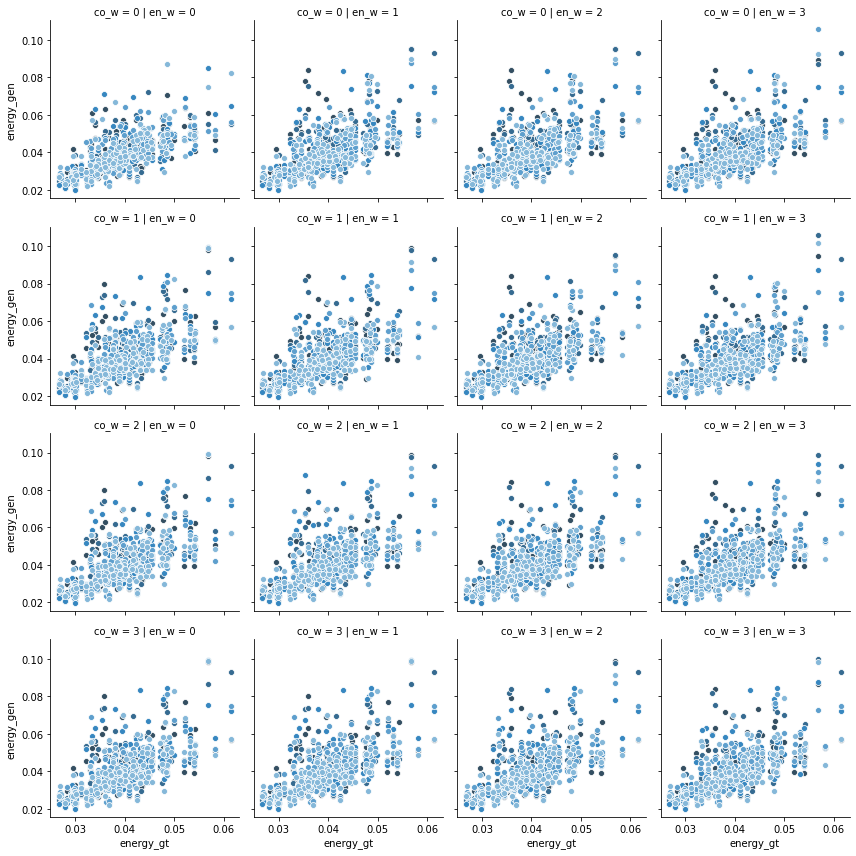

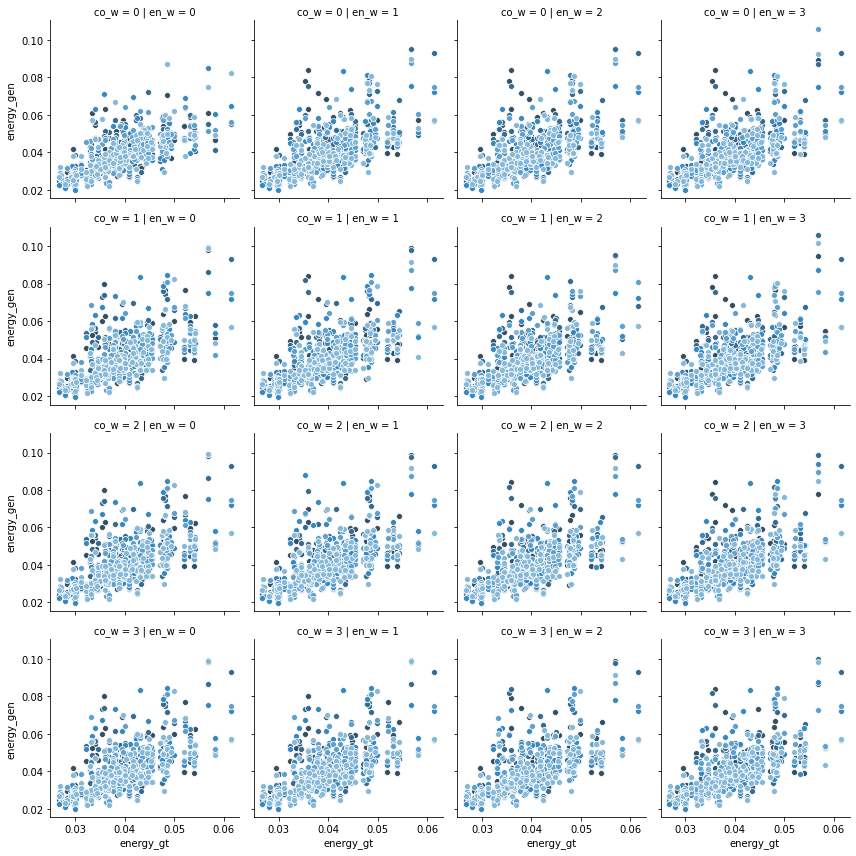

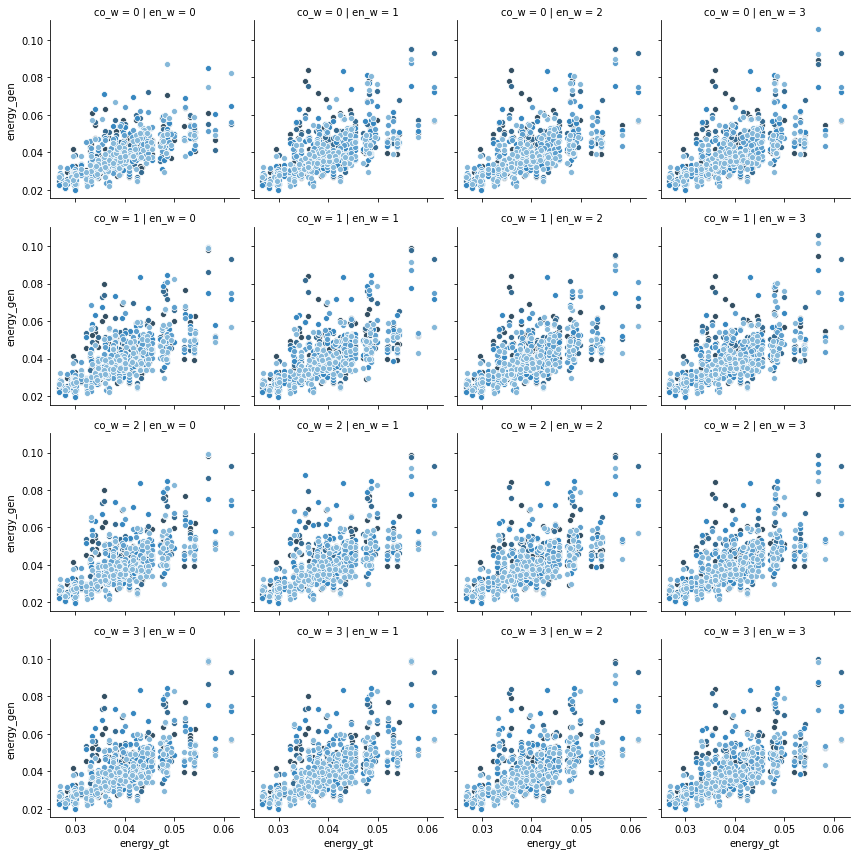

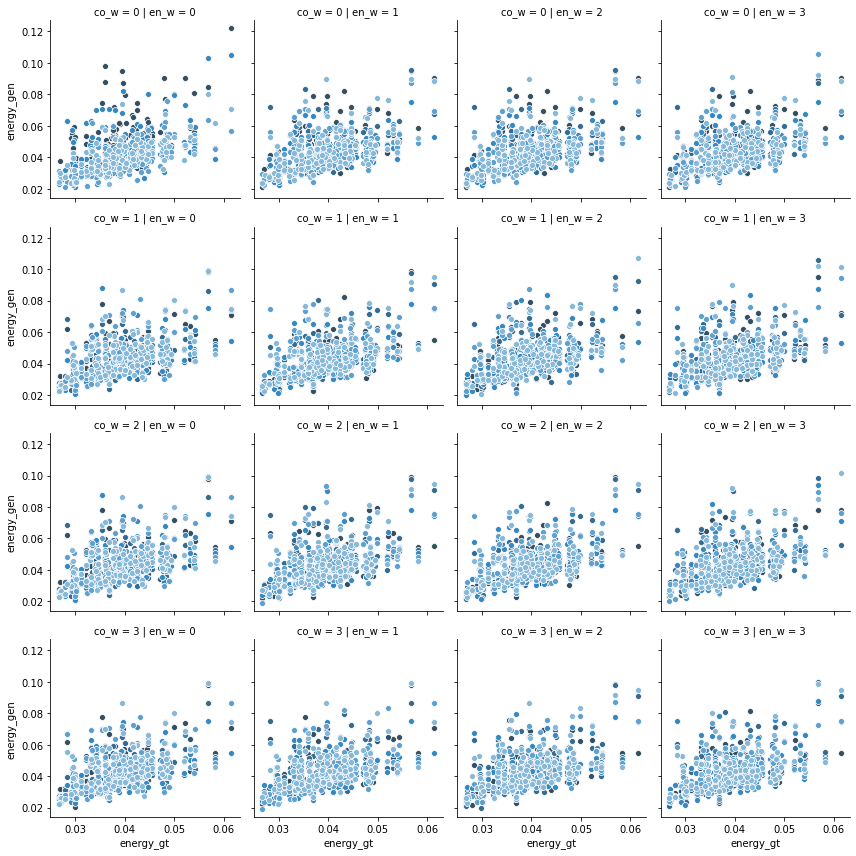

In [10]:
import seaborn as sns
ns_500 = merged[merged.ns == 50]
for edge, ed_df in ns_500.groupby('ed_w'):
    g = sns.FacetGrid(
        data=ed_df,
        row='co_w',
        col='en_w',
        hue='rep_n',
        palette='Blues_d'
    )
    g.map(sns.scatterplot, 'energy_gt', 'energy_gen')
    print(edge)

In [16]:
rep_1_df = merged[merged.rep_n == 0]
gl_500_df = rep_1_df[rep_1_df.ns == 500]

Text(0.5, 1.0, 'Energy Correlation')

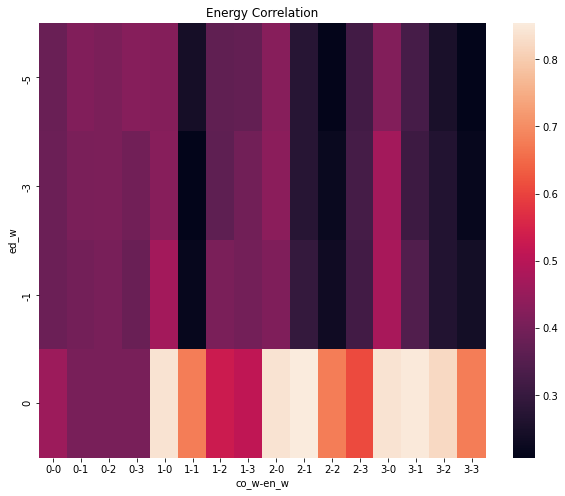

In [17]:
en_corr = gl_500_df.groupby(['ns', 'ed_w', 'co_w', 'en_w']).apply(
    lambda x: stats.pearsonr(x.energy_gt, x.energy_gen)
)

en_corr_df = pd.DataFrame(en_corr.tolist(), index=en_corr.index, columns=['r', 'p']).reset_index()
en_piv = en_corr_df.pivot_table(
    index=['ed_w'],
    columns=['co_w', 'en_w'],
    values='r',
)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(en_piv, ax=ax)
ax.set_title('Energy Correlation')

Text(0.5, 1.0, 'Contrast Correlation')

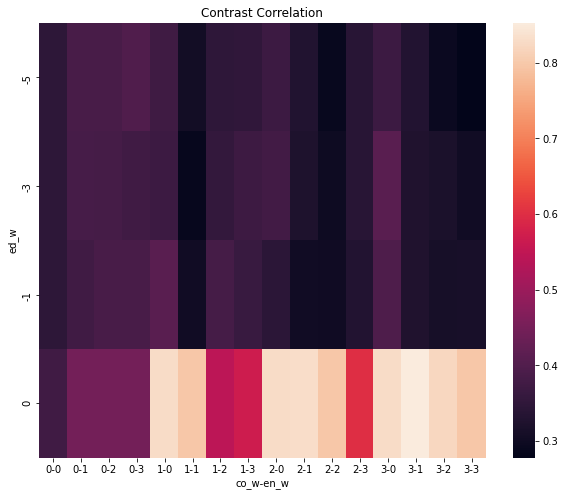

In [19]:
co_corr = gl_500_df.groupby(['ns', 'ed_w', 'co_w', 'en_w']).apply(
    lambda x: stats.pearsonr(x.contrast_gt, x.contrast_gen)
)

co_corr_df = pd.DataFrame(co_corr.tolist(), index=co_corr.index, columns=['r', 'p']).reset_index()
co_piv = co_corr_df.pivot_table(
    index=['ed_w'],
    columns=['co_w', 'en_w'],
    values='r',
)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(co_piv, ax=ax)
ax.set_title('Contrast Correlation')

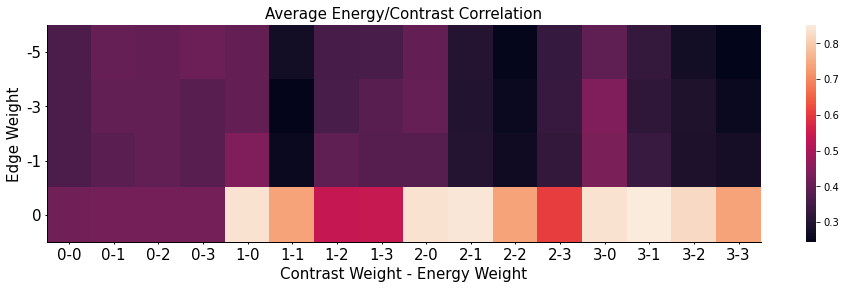

In [34]:
fig, ax = plt.subplots(figsize=(16,4))
sns.heatmap((co_piv + en_piv)/2, ax=ax)
ax.set_title('Average Energy/Contrast Correlation', fontsize=15)
ax.set_xlabel('Contrast Weight - Energy Weight')
ax.set_ylabel('Edge Weight')
fmt.despine_thicken_axes(ax, lw=1, fontsize=15)